# Optimal bet size and Kelly Criterion

In this notebook we'll study a simple discrete game. We can play as may times as we want and each round we bet an amount $a$ and get $a(1+u)$ with probability $p$ and otherwise $a(1-d)$ with probability $q=1-p$. For instance, if $p=0.5$ and $u=d=0.1$, this means that each round we have a 50-50 chance of winning or losing $10\%$ of our bet. Several questions naturally arise:
1) for what values of $p, u, d$ is this game fair?
2) even if this game is fair, do we want to play it?
3) if we want to play it, how to do so optimally?

Note that question 1 is quite classic, but as we'll see the long-term outcomes of this game are surprising, hence question 2. Finally, question 3 will introduce Kelly's criterion.

## First mathematical analysis

For now, let's assume that we start with an initial wealth $W_0=1$ and bet all our wealth at each round. We will denote $W_n$ our wealth after playing $n$ rounds, such that $$\mathbb{E}[W_{n+1}]=p\cdot (1+u)W_n + q\cdot (1-d)W_n=W_n + (pu-qd)W_n = (1+\alpha)W_n$$

Therefore, this game is fair if $\alpha=pu-qd=0$ and we want to play when $\alpha>0$, in which case our wealth grows exponentially fast <b>in expected value</b>, since $\mathbb{E}[W_n]=(1+\alpha)^n W_0$.

Let's simulate some games with various parameters and see what we get.

### 0. Import librairies

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

### 1. Define the game

In [220]:
BRIGHT_RED = '#FF0000' # nice red color for plots

class Game:

    """
    Simulates a game where you bet B and then you get B*(1+u) with probability p or B*(1-d) with probability q=1-p.
    """

    def __init__(self, u: float, d: float, p: float) -> None:
        self.u = u
        self.d = d
        self.p = p
        self.f_opt = p/d - (1-p)/u # fraction of wealth to bet at each turn to maximize the growth rate (Kelly criterion)
        self.initial_wealth = 1

    
    def play(self, batch_size: int, n_points: int, f: float=1) -> None:
        """
        Simulates batch_size games where we play n_points turn, and at each turn, we bet a fraction f of our wealth 
        which is multiplied by (1+u) with probability p or (1-d) with probability q=1-p.
        """
        wealth_paths = np.zeros((batch_size, n_points+1))
        wealth_paths[:,0] = self.initial_wealth

        for i in range(n_points):
            rate = np.random.choice([self.u,-self.d], p=[self.p,1-self.p], size=batch_size)
            wealth_paths[:,i+1] = wealth_paths[:,i] + f * wealth_paths[:,i] * rate

        self.wealth_paths = wealth_paths


    def plot(self, log: bool=True, ax: plt.Axes=None) -> None:
        """
        Plots the wealth paths.
        """
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.wealth_paths.T)
        ax.set_xlabel("Turn")
        ax.set_ylabel("Wealth")
        if log:
            ax.set_yscale("log")
        ax.set_title(f"u={self.u}, d={self.d}, p={self.p}")
    

    def plot_histogram(self, log: bool=True, ax: plt.Axes=None) -> None:
        """
        Plots the histogram of log(final wealth).
        """
        if ax is None:
            fig, ax = plt.subplots()
        final_wealths = self.wealth_paths[:,-1]

        if log:
            final_wealths = np.log(final_wealths)

        ax.hist(final_wealths, bins=30)
        ax.set_xlabel("log(final wealth)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"u={self.u}, d={self.d}, p={self.p}")


    def plot_mean_wealth(self, ax: plt.Axes=None) -> None:
        """
        Plots the mean wealth as a function of the turn.
        """
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(np.mean(self.wealth_paths, axis=0), c=BRIGHT_RED)
        ax.set_xlabel("Turn")
        ax.set_ylabel("Mean wealth")
        ax.set_title(f"u={self.u}, d={self.d}, p={self.p}")

    def plot_median_wealth(self, ax: plt.Axes=None) -> None:
        """
        Plots the median wealth as a function of the turn.
        """
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(np.median(self.wealth_paths, axis=0), c=BRIGHT_RED)
        th_median = lambda n: self.initial_wealth * (1+self.u)**(n*self.p) * (1-self.d)**(n*(1-self.p))
        ax.plot([th_median(n) for n in range(self.wealth_paths.shape[1])], c="black", ls="--", label="Theoretical median")
        ax.set_xlabel("Turn")
        ax.set_ylabel("Median wealth")
        ax.set_title(f"u={self.u}, d={self.d}, p={self.p}")
        ax.legend()


### 3. Simulate some games

#### A. Fair game

Let's start with a fair game i.e. $pu-qd=0$. We'll take $u=d=0.1$ and $p=0.5$.

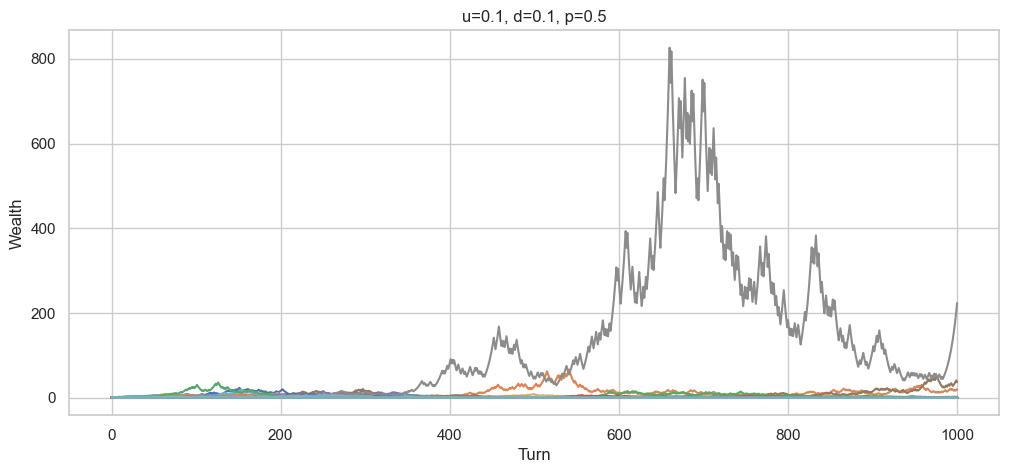

In [222]:
u = d = 0.1
p = 0.5
n_games = 100
n_points = 1000

game = Game(u, d, p) # create the game
game.play(n_games, n_points) # play the game

game.plot(log=False) # plot the wealth paths

We see that although a few wealth paths go way up (before going down), most paths stay very low, and nearly all of them end very low. It feels like a log scale on the y axis would make things more visible. Let's try that.

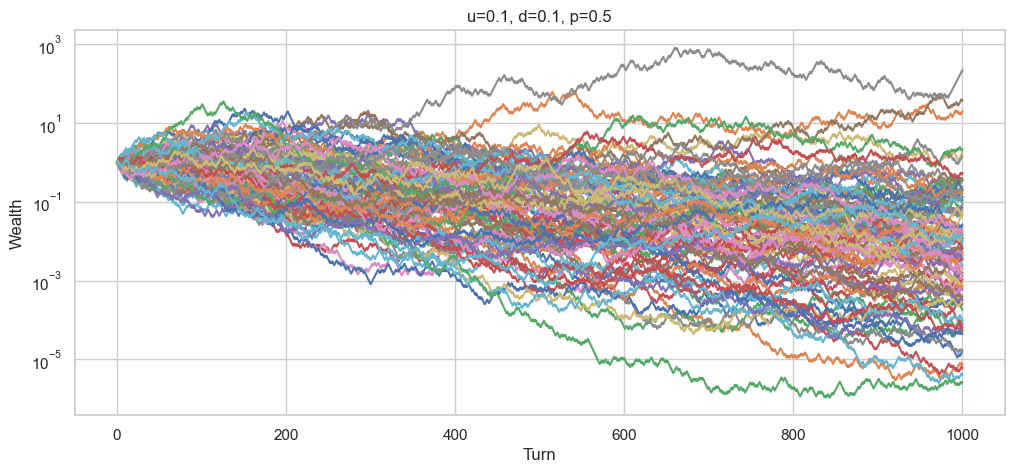

In [223]:
game.plot(log=True) # plot the wealth paths in log scale

We obtain something which looks very, very much like a geometric random walk. Let's look at the dynamic of $\ln(W_n)$ to understand what's going on. We have that $$\mathbb{E}[\ln(W_{n+1})]=p\cdot \ln \big(W_n(1+u)\big) + q\cdot \ln \big(W_n(1-d)\big)v = \ln(W_n) + p\ln(1+u) + q\ln(1-d)$$

We see that the logarithm of our wealth $\ln(W_n)$ follows a geometric random walk. Plugging in our values of $u, d, p$, we find that $\ln(1+u)\simeq 0.0953$ and $\ln(1-d)\simeq - 0.1054$, such that with $p=\frac{1}{2}$, $\ln(W_n)$ follows a random walk that pulls it towards $-\infty$.

We thus $\ln(W_n) \xrightarrow[n]{a.s.}-\infty$ (and in $L^1$), such that $W_n \xrightarrow[n]{a.s.} 0$.

So what happened? How can we simultaneously have $\mathbb{E}[W_n]=W_0=1$ (since $\alpha=1$) and $W_n \xrightarrow[n]{a.s.} 0$? The explanation is that although almost all paths end near $0$, a few of them reach tremendous heights (hence the need for a log scale for properly visualize the paths). These "lucky fews" are large enough to move the entire expected value up from 0.

It can thus be interesting to look at the median value, which is the mode and happens when you get half wins and half losses, such that the median $M_n$ of $W_n$ verifies $$\mathbb{E}[M_n]=W_0\cdot (1+u)^{n/2} \cdot (1-d)^{n/2}$$

Plugging in our values, we have $$\mathbb{E}[M_n]=W_0\cdot (0.99)^{n/2} \xrightarrow[n]{} 0$$

This means that although this game is fair when $\alpha=0$, in practice you're likely to lose all your money, unless you win an enormous amount of money. Let's look at the mean and median gains to better see this.

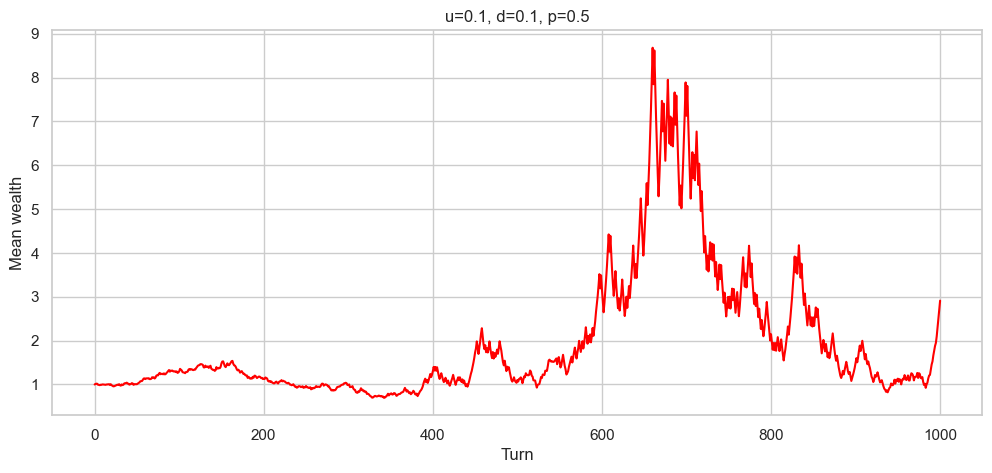

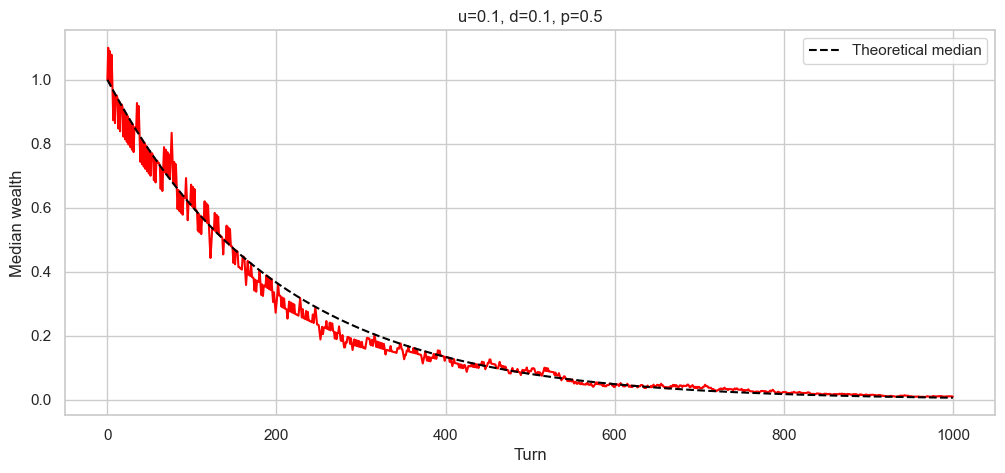

In [224]:
game.plot_mean_wealth() # plot the mean wealth as a function of the turn
game.plot_median_wealth() # plot the median wealth as a function of the turn

As expected, the median wealth (i.e. what you'd likely end up with if you played this game) converges towards 0

It's less clear with the empirical expected value of our wealth $\bar{W_n}$ converges towards 0. Maybe due to some rounding errors resulting in $\alpha < 1$ and thus $\mathbb{E}[W_n] \xrightarrow[n]{} 0$ as the errors compound.

#### B. Putting the odds in our favor.

Let's now increase $u$ to put the odds in our favor and see if we still end up losing most of the time.

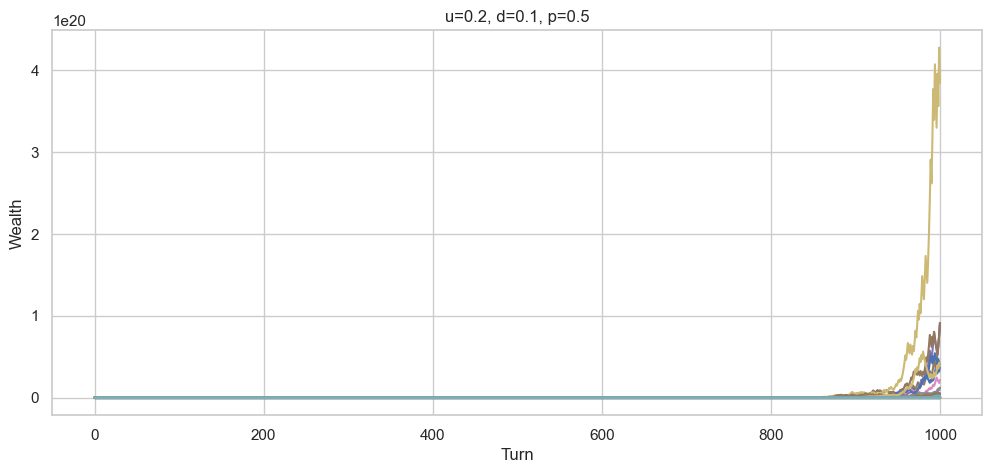

In [225]:
u = 0.2
d = 0.1
p = 0.5
n_games = 100
n_points = 1000

game = Game(u, d, p) # create the game
game.play(n_games, n_points) # play the game

game.plot(log=False) # plot the wealth paths

This time, it seems that we make some money in the end. Again, we'll need log scale on the y axis to better visualize the results.

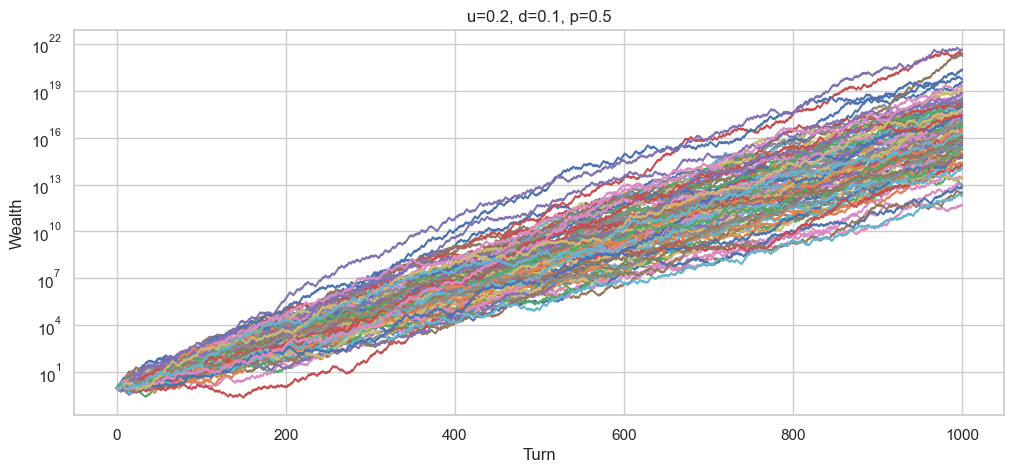

In [218]:
game.plot(log=True) # plot the wealth paths in log scale

As expected, we find another geometric Brownian motion, but this time biased in our favor since $\ln(1+u) >|\ln(1-d)|$. We thus have $\ln(W_n) \xrightarrow[n]{a.s.}+\infty$ (and in $L^1)$ such that $W_n \xrightarrow[n]{a.s.} +\infty$.

This time the median verifies $$\mathbb{E}[M_n]=W_0\cdot (1.08)^{n/2} \xrightarrow[n]{.} +\infty$$

Let's look at the plots of $\bar{W_n}$ and $M_n$.

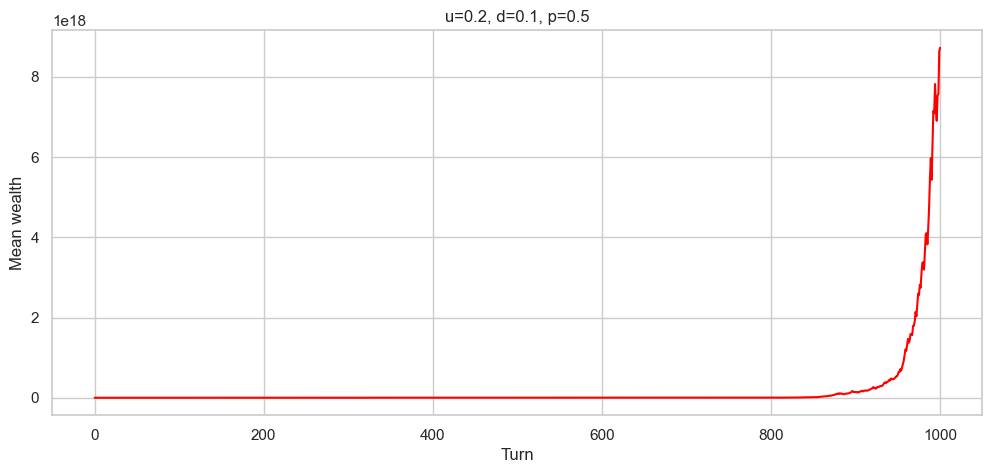

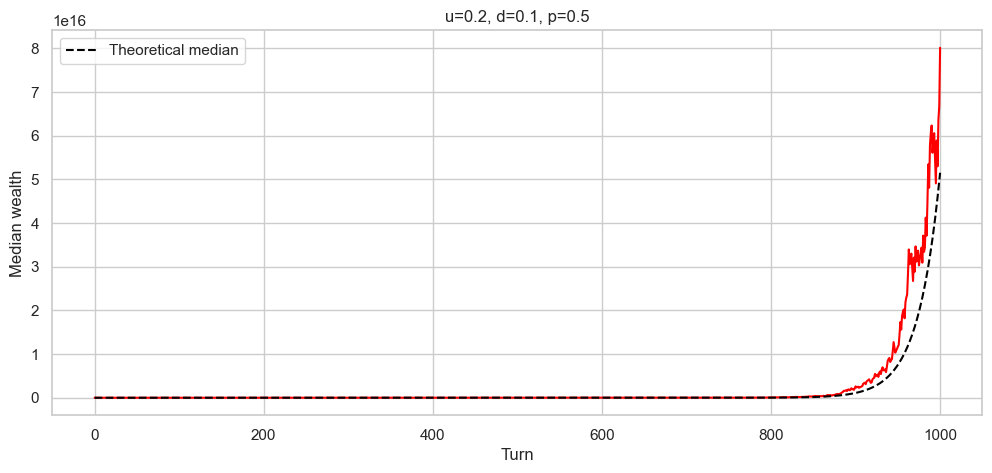

In [227]:
game.plot_mean_wealth() # plot the mean wealth as a function of the turn
game.plot_median_wealth() # plot the median wealth as a function of the turn

#### C. Putting the odds only slightly in our favor

This time we increase $u$ again, but only by $0.01$. Let's see if we still want to play this game.

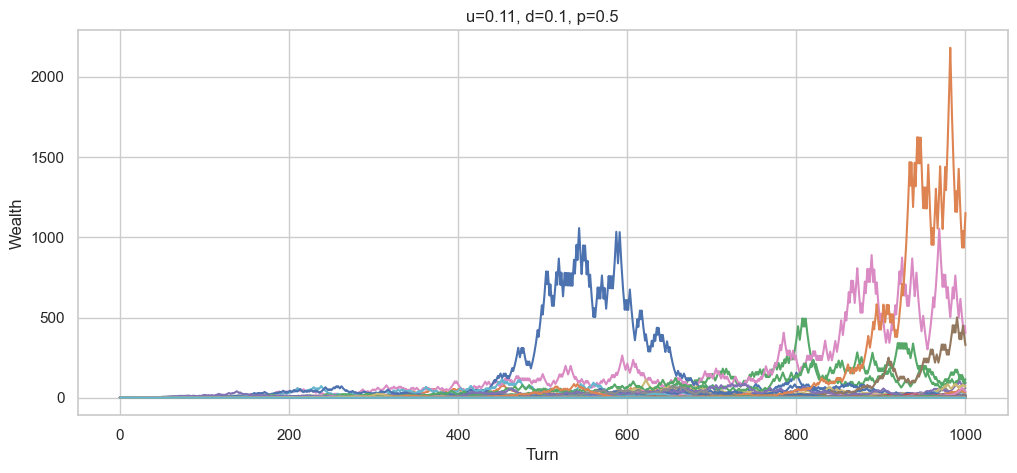

In [231]:
u = 0.11
d = 0.1
p = 0.5
n_games = 100
n_points = 1000

game = Game(u, d, p) # create the game
game.play(n_games, n_points) # play the game

game.plot(log=False) # plot the wealth paths

This time it's not so clear. Let's put a log scale on the y axis and see what we get.

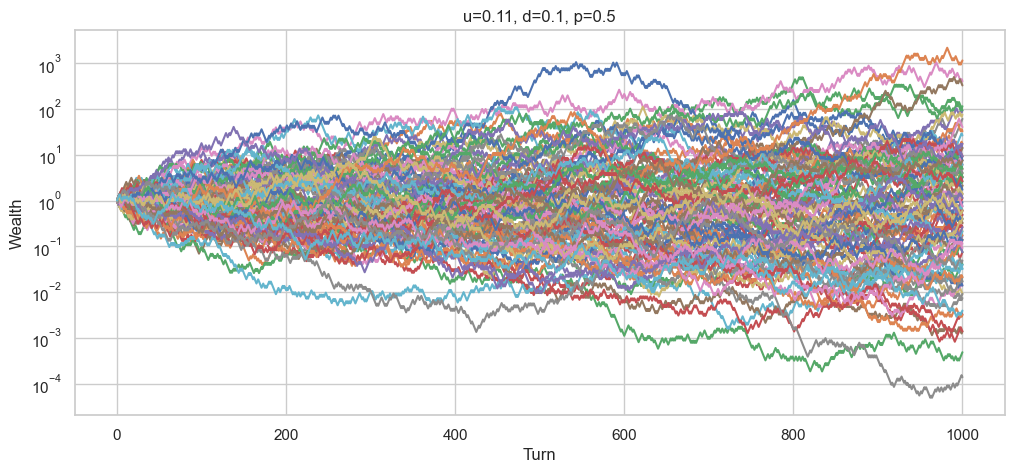

In [233]:
game.plot(log=True) # plot the wealth paths in log scale

Hmm. It's very close. In fact, we can compute $\ln(1+u)\simeq 0.10436$ and $\ln(1-d)\simeq -10.536$ such that $\ln(1+u) < |\ln(1-d)|$ such that $\ln(W_n)$ follows a random walk that pulls it towards $-\infty$, like in A. We thus have $W_n \xrightarrow[n]{a.s.} 0$, hence this game is not to be played. And at the same time, we have $W_n \xrightarrow[n]{L^1} +\infty$ since $\alpha>1$!

The graphs below confirm our reasoning.

Thus, we have a game that in theory is biased in our favor (since $W_n \xrightarrow[n]{L^1} +\infty$) and yet in practice it will make us lose all our money (since $W_n \xrightarrow[n]{as} 0$)!

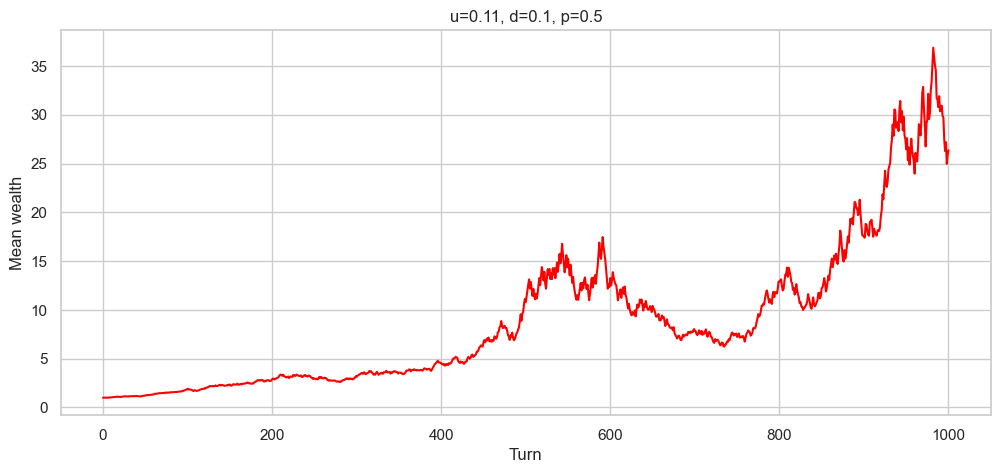

In [236]:
game.plot_mean_wealth() # plot the mean wealth as a function of the turn

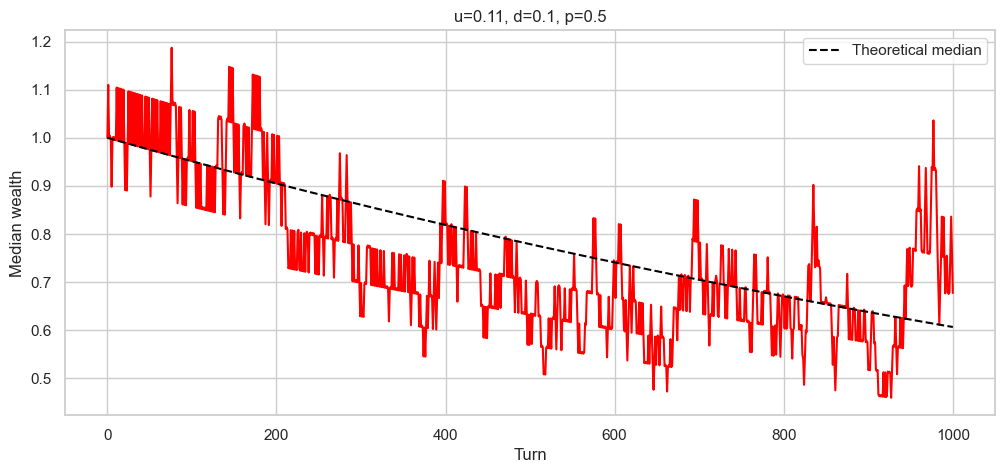

In [237]:
game.plot_median_wealth() # plot the median wealth as a function of the turn

## Playing smart: Kelly's criterion

The previous result is quite frustrating: the odds are in our favor and yet we're losing! Maybe we could play smarter?

Since our game is multiplicative (and not additive), we've found insights in looking at the logarithm of our wealth instead of the wealth itself. Likewise, it feels like instead of betting all our wealth at the same time, betting a constant fraction $f$ of it at each round could yield better results.

In this case, we would have $$\mathbb{E}[\ln(W_{n+1})]=p\cdot \ln \big(W_n(1+fu) \big) + q\cdot \ln \big(W_n(1-fd)\big)= \ln(W_n) + p\ln(1+fu)+q\ln(1-fd)$$

We can differentiate with respect to $f$ in order to find the optimal fraction, yielding $$f^*=\frac{p}{d}-\frac{q}{u}$$
This equation is better known as Kelly's criterion, who first derived it in 1956.

Let's see if our profits get better using $f^*$.

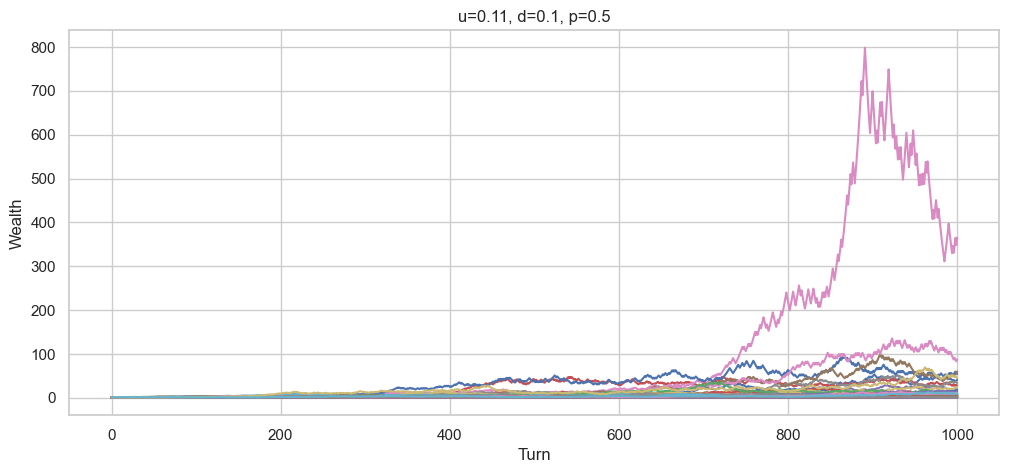

In [238]:
u = 0.11
d = 0.1
p = 0.5
n_games = 100
n_points = 1000

game = Game(u, d, p) # create the game
game.play(n_games, n_points, f=game.f_opt) # play the game

game.plot(log=False) # plot the wealth paths

Again, hard to see, let's use log scale on the y axis.

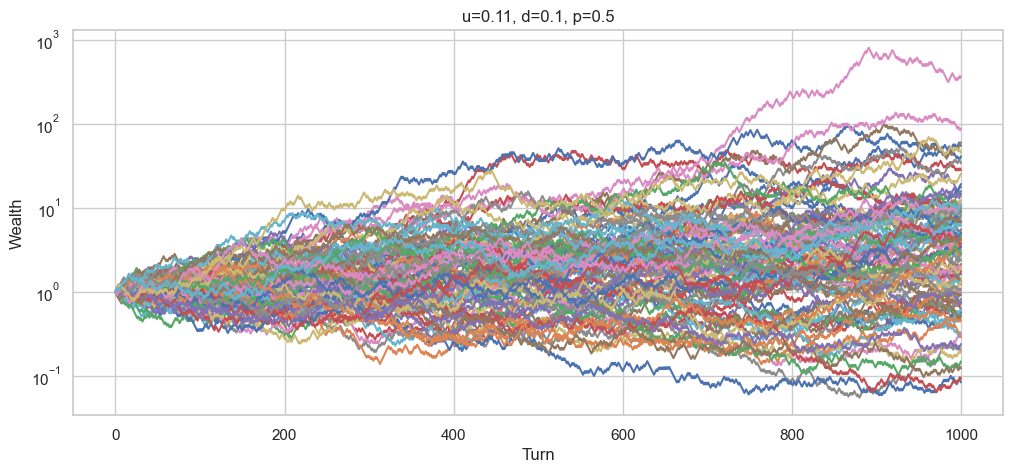

In [239]:
game.plot(log=True) # plot the wealth paths in log scale

This time, it seems that the random walk trends slightly upwards. Let's look at the graphs of $\bar{W_n}$ and $M_n$.

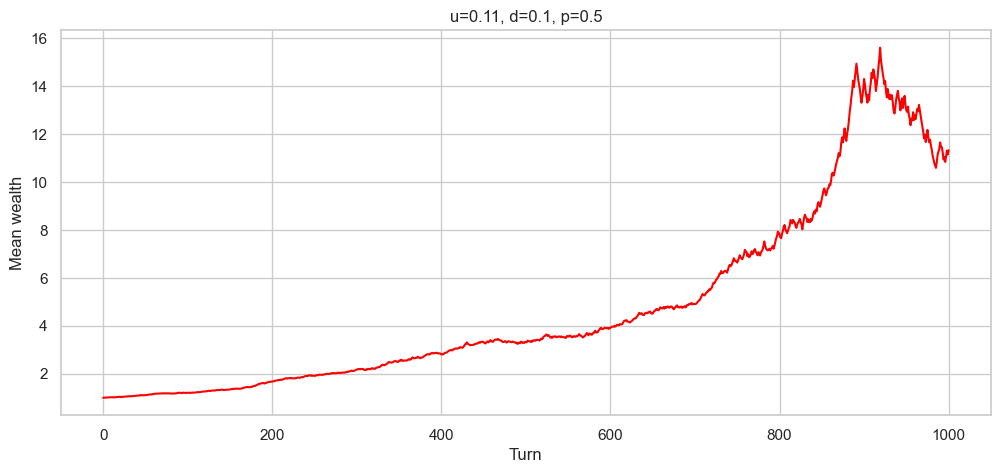

In [240]:
game.plot_mean_wealth() # plot the mean wealth as a function of the turn

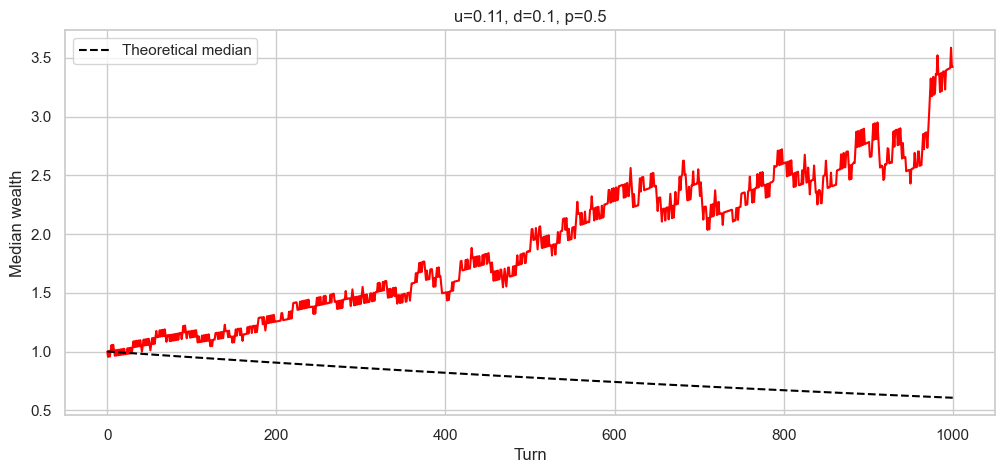

In [241]:
game.plot_median_wealth() # plot the median wealth as a function of the turn

Yay! This time we have both the mean and the median slopping upwards. In other words, playing smart has allowed us to take advantage of the good odds we had.

But what exactly happened?

Plugging in our values, we find that $\beta = p\ln(1+f^*u) + q\ln(1-f^*d) \simeq 0.0011 > 0$. Since $\mathbb{E}[\ln(W_{n+1})]=\ln(W_n)+\beta$, we have $\ln(W_n) \xrightarrow[n]{a.s.} +\infty$ (and in $L^1$) such that $W_n \xrightarrow[n]{a.s.} +\infty$.

### The End: can we do better?

To recap, we've seen that when the odds are (even slightly) in our favor and we're playing the optimal fraction $f^*=\frac{p}{d}-\frac{q}{u}$ of our wealth at each step, we can realize gains <b>in practice</b> (and not just in expected value), because we have $W_n \xrightarrow[n]{a.s.} +\infty$ (and not just $W_n \xrightarrow[n]{L^1} +\infty$.)

A natural question is: can we do better? We've seen that setting $f=f^*$ is optimal within the subspace of constant-fraction strategies (it is notably better than setting $f=1$), but perhaps better strategies exists. It turns out Kelly's criterion is optimal among all strategies. The proof is slightly more technical but it can be found in [Kelly's original paper](https://www.princeton.edu/~wbialek/rome/refs/kelly_56.pdf).